# Support Vector Machine Model

## Instructions

### Main Tasks:
1. **SVM Model Training with Scikit-Learn**
   - Use KDD99 dataset
   - Classify DoS vs Non-DoS attacks
   - Utilize all features

2. **Kernel Comparison**
   - Run SVM model with at least 4 different kernels
   - Compare results across kernels
   - Analyze pros and cons of each kernel

3. **Feature Selection & Visualization**
   - Select two important features
   - Train SVM using only selected features
   - Visualize decision boundary for:
     - Linear kernel
     - RBF kernel
   - Subsample training data for visualization
   - Discuss observations

### Important Notes:
- Use label encoder or one-hot encoding for categorical variables
- Reference visualization examples:
  - [Scikit-learn Iris Example (0.18)](https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html)
  - [Scikit-learn Iris SVC Example](https://scikit-learn.org/dev/auto_examples/svm/plot_iris_svc.html#sphx-glr-auto-examples-svm-plot-iris-svc-py)
- Dataset is imbalanced:
  - Use `imblearn.under_sampling.RandomUnderSampler`
  - Take smaller fraction of dataset (SVM is computationally intensive)
  - Consider scaling data using `sklearn.preprocessing.MinMaxScaler`

### Attack Types in Dataset:
#### DoS Attacks:
- back
- land
- neptune
- pod
- smurf
- teardrop

#### Probe Attacks:
- ipsweep
- nmap
- portsweep
- satan

#### U2R (User to Root) Attacks:
- buffer_overflow
- loadmodule
- perl
- rootkit

#### R2L (Remote to Local) Attacks:
- ftp_write
- guess_passwd
- imap
- multihop
- phf
- spy
- warezclient
- warezmaster

**Due Date:** February 23, 2025 11:59 PM  
**Available:** February 5, 2025 11:59 PM  
**Closes:** February 23, 2025 11:59 PM

In [ ]:
import numpy as np
import os # this is info about the library/method used https://docs.python.org/3/library/os.path.html
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression # importing the logistic regression model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler # For undersampling

## Gathering Data For the Assignemnt

Need to gather information from the KDD99 dataset for Dos vs Non Dos using all the features
* Get the data for Dos and Non dos

In [ ]:
#https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"

# Load the dataset (no column names in the raw file)
df = pd.read_csv(url, compression='gzip')

# Display the first 5 rows
df.tail()

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
494015,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494016,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.


In [ ]:
#Remote duplicated values 
df.drop_duplicates(inplace=True)
print(df.memory_usage(deep=True).sum(), "bytes")
df.shape

81226500 bytes


(145586, 42)

Now will need to change the data to make it formatted properly with the right features. This will call on the name file from kd99 dataset
* This also means adding the intrusion types feature name as well.

In [ ]:

names_file_path = "kiddcup_names.txt"

# Read feature names from the file
feature_names = []
with open(names_file_path, "r") as f:
    for line in f.readlines()[1:]:  # Skip the first line (it describes the class label - these are the classes)
        feature_names.append(line.split(":")[0])  # Extract only the feature name

# Add the label column at the end
feature_names.append("intrusion_types")

# Print the final feature list
df.columns = feature_names # match column names
df.head()  # Check if column names are applied correctly

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion_types
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [ ]:
# Want to see what the class_level column looks like as a graph

# Check unique values in the last column (assuming it contains attack labels)
print(df.iloc[:, -1].value_counts())
df['intrusion_types']

normal.             87832
neptune.            51820
back.                 968
teardrop.             918
satan.                906
warezclient.          893
ipsweep.              651
smurf.                641
portsweep.            416
pod.                  206
nmap.                 158
guess_passwd.          53
buffer_overflow.       30
warezmaster.           20
land.                  19
imap.                  12
rootkit.               10
loadmodule.             9
ftp_write.              8
multihop.               7
phf.                    4
perl.                   3
spy.                    2
Name: intrusion_types, dtype: int64


0         normal.
1         normal.
2         normal.
3         normal.
4         normal.
           ...   
494016    normal.
494017    normal.
494018    normal.
494019    normal.
494020    normal.
Name: intrusion_types, Length: 145586, dtype: object

Process the data to encoder or one hot encoding categorical variables

In [ ]:
# Finding out what features are categorical
print(df.dtypes)


duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

The next step is have a classification for Dos vs Non Dos
* Dos: denial-of-service, e.g., syn flood
* Non DoS are attacks that are not DoS

Before we continue, lets get the different attack types in an stored structure

In [ ]:
# Getting the Attacks line from data set first

with open(names_file_path, "r") as f:
    # Read the first line, which contains attack types info
    attack_line = f.readline().strip()
attack_types = attack_line.split(",")  # Adjust the delimiter if necessary
attack_types, len(attack_types)

attack_types



['back',
 'buffer_overflow',
 'ftp_write',
 'guess_passwd',
 'imap',
 'ipsweep',
 'land',
 'loadmodule',
 'multihop',
 'neptune',
 'nmap',
 'normal',
 'perl',
 'phf',
 'pod',
 'portsweep',
 'rootkit',
 'satan',
 'smurf',
 'spy',
 'teardrop',
 'warezclient',
 'warezmaster.']

Dos Attacks are defined as:
* [back, land, neptune, pod, smurf, teardrop]

None Dos is everything else

In [ ]:
# List of Dos attack types (with trailing periods)
dos_types = ['back.', 'land.', 'neptune.', 'pod.', 'smurf.', 'teardrop.']

def classify_dos(row):
    return "DoS" if row in dos_types else "non-DoS"

# Apply the classification function to the label column
df['class_label'] = df['intrusion_types'].apply(classify_dos)

# Verify if probe attacks are now labeled correctly
print(df['class_label'].value_counts())
df.head()


non-DoS    91014
DoS        54572
Name: class_label, dtype: int64


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,intrusion_types,class_label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,non-DoS
1,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,non-DoS
2,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,non-DoS
3,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,non-DoS
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,non-DoS


In [ ]:
# Finding out what features are categorical
print(df.dtypes)

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

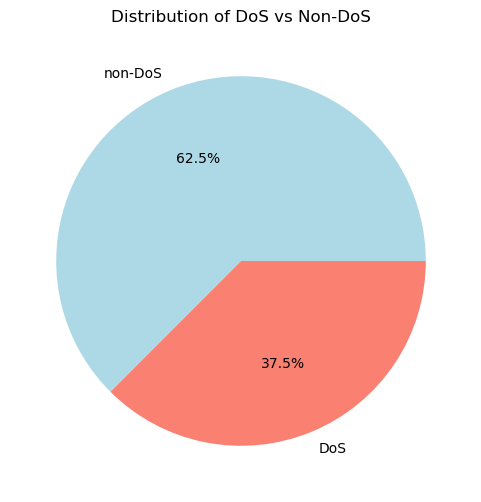

In [ ]:
# Count the number of occurrences of each class
class_counts = df['class_label'].value_counts()
# Calculate percentages
percentages = class_counts / class_counts.sum() * 100
# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
plt.title('Distribution of DoS vs Non-DoS')
plt.show()

In [ ]:
# So Now we know targets are: protocol_type, service, flag, intrusion_types, and class_label
label_enc = LabelEncoder()
df['service'] = label_enc.fit_transform(df['service'])
df['intrusion_types'] = label_enc.fit_transform(df['intrusion_types'])

# Apply One-Hot Encoding for 'protocol_type', 'flag', and 'class_label'
df = pd.get_dummies(df, columns=['protocol_type', 'flag', 'class_label'], drop_first=True)
df.head()

,duration,service,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,class_label_non-DoS
0,0,22,181,5450,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,0,22,239,486,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
2,0,22,235,1337,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
3,0,22,219,1337,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
4,0,22,217,2032,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1


## Setting up the Training Data for the SVM Model Process 
* This means setting up the training data
* Using Sciketlearn SVM methods and run it on the data set
* Run it at least 4 times with different kernel each time
* Pick two features which you think are important and visual the decision boundary



In [ ]:
from sklearn.model_selection import train_test_split # using for data spliting process
# Features (X) and target (y)
X = df.drop(columns=['class_label_non-DoS'])  # Drop target column
y = df['class_label_non-DoS']  # Target variable (0 = Non-Probe, 1 = Probe)

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



We need to add undersampling process here before going to training process so Wil use the Random UnderSampling 

In [ ]:
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Fit the resampler to the training data
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Check the class distribution after undersampling
print(f"Class distribution after undersampling: {y_train_res.value_counts()}")

Class distribution after undersampling: 0    43678
1    43678
Name: class_label_non-DoS, dtype: int64


set()


## Steps to Diagnose and Resolve:
# Verify Data Splitting: Double-check that your train-test split and undersampling are correctly done.

Ensure the model is trained only on the training data and evaluated on the separate test data.
Evaluate with More Realistic Metrics: Instead of relying on the classification report, you might want to check the confusion matrix to see if the model is truly generalizing or just memorizing patterns. Use confusion_matrix(y_test, y_pred) to analyze how the model is performing across different classes.

# Cross-validation:

Perform cross-validation instead of a single train-test split. This will provide more reliable performance estimates and reduce the chances of overfitting or testing on a non-representative test set.
Example:
python
```
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svm_model, X_train_scaled, y_train_res, cv=5)
print(f"Cross-validation scores: {scores}")
```

# Check for Data Leakage:

Ensure no information from the test set is leaked into the training process (e.g., scaling the whole dataset before splitting).

# Test with Larger Data Subsets:

Try working with a larger portion of the dataset, if feasible, since SVMs can perform poorly on smaller datasets (they can overfit easily). You can also try a smaller fraction of features if running on the full dataset is computationally expensive.

# Hyperparameter Tuning:

Tune the C parameter in the SVM model to control overfitting. A higher C value allows less margin, potentially leading to overfitting, while a lower C value provides a larger margin but may underfit.
Experiment with kernel parameters (for example, the degree of the polynomial kernel) to observe their impact.


 # Examine Feature Importance:

If possible, perform feature selection (like using SelectKBest or RandomForestClassifier) to identify which features are actually contributing the most to your predictions and see if the model is using irrelevant features to overfit.

## Now using  SVC and SVM processes

In [174]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Applying PCA to reduce 2D for visualization 
from sklearn.decomposition import PCA  # PCA to reduce to 2D for plotting
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification

In [180]:
# Step 2: Scale the data using MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to both the undersampled training set and the original test set
X_train_scaled = scaler.fit_transform(X_train_res)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)  # Only transform on test data

# # Initialize and train the model
svm_model = SVC(kernel='linear', C=0.01,random_state=42)
svm_model.fit(X_train_scaled, y_train_res)

score = svm_model.score(X_test_scaled, y_test)
print(f"Model accuracy: {score}")

# Predict on the test data
y_pred = svm_model.predict(X_test_scaled)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
# Predict on the test data
# y_pred = svm_model.predict(X_test_scaled)

# # Print classification report
# print(f"Classification Report for {kernel} Kernel:")
# print(classification_report(y_test, y_pred))


Model accuracy: 0.9894223504361563
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10894
           1       0.98      1.00      0.99     18224

    accuracy                           0.99     29118
   macro avg       0.99      0.99      0.99     29118
weighted avg       0.99      0.99      0.99     29118



In [182]:
# Printing the cross_validation scores 

scores = cross_val_score(svm_model, X_train_scaled, y_train_res, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean()}")

Cross-validation scores: [0.98843864 0.98769389 0.98586229 0.98757942 0.98620571]
Mean accuracy: 0.987155990628531


In [185]:
# Now to test it with at least 4 kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Loop through each kernel and train the model
for kernel in kernels:
    # Initialize the SVM model
    svm_model = SVC(kernel=kernel, C=0.01, random_state=42)
    
    # Fit the model
    svm_model.fit(X_train_scaled, y_train_res)
    
    # Get the accuracy score
    score = svm_model.score(X_test_scaled, y_test)
    print(f"Kernel: {kernel}, Accuracy: {score}")
    
    # Predict on the test data
    y_pred = svm_model.predict(X_test_scaled)
    
    # Print classification report for each kernel
    print(f"Classification Report for {kernel} kernel:")
    print(classification_report(y_test, y_pred))
    print('-' * 50)  # Print separator between kernel results

Kernel: linear, Accuracy: 0.9894223504361563
Classification Report for linear kernel:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10894
           1       0.98      1.00      0.99     18224

    accuracy                           0.99     29118
   macro avg       0.99      0.99      0.99     29118
weighted avg       0.99      0.99      0.99     29118

--------------------------------------------------
Kernel: poly, Accuracy: 0.9902465828697026
Classification Report for poly kernel:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     10894
           1       0.99      1.00      0.99     18224

    accuracy                           0.99     29118
   macro avg       0.99      0.99      0.99     29118
weighted avg       0.99      0.99      0.99     29118

--------------------------------------------------
Kernel: rbf, Accuracy: 0.9900748677793805
Classification Report for rbf kern

## Compare the Results and discussing pros/cons of each one kernel 

#### 1. **Linear Kernel**
   - **Accuracy**: 98.94%
   - **Pros**: The linear kernel performs exceptionally well with high accuracy and balanced precision/recall. It is computationally efficient and ideal for linearly separable data. 
   - **Cons**: While fast, it may fail to capture complex decision boundaries and could **underfit** for non-linear data.

#### 2. **Polynomial Kernel**
   - **Accuracy**: 99.02%
   - **Pros**: Slightly outperforms the linear kernel in terms of accuracy, especially for non-linear data. It is more flexible, allowing the model to capture more complex relationships.
   - **Cons**: The polynomial kernel can be **computationally expensive** as the degree increases, and there’s a **risk of overfitting** if the degree is too high.

#### 3. **RBF (Radial Basis Function) Kernel**
   - **Accuracy**: 99.01%
   - **Pros**: The RBF kernel handles non-linear data well and is one of the most widely used kernels. It can model complex decision boundaries in high-dimensional spaces.
   - **Cons**: It is computationally more expensive, and the **gamma parameter** requires careful tuning to avoid overfitting or underfitting.

#### 4. **Sigmoid Kernel**
   - **Accuracy**: 93.39%
   - **Pros**: Useful for modeling non-linear relationships, similar to neural networks.
   - **Cons**: Underperforms compared to other kernels, with lower precision and recall. The **sigmoid kernel is rarely used** due to poor performance and difficulty in parameter tuning.

---

### **Summary & Discussion**

The **Linear kernel** is fast and works well with linearly separable data but may miss complex decision boundaries, leading to **underfitting**. The **Polynomial kernel** provides better flexibility and performance but is computationally more expensive and can **overfit** with high degrees. The **RBF kernel** excels in handling non-linear data and performs well across datasets but requires **careful tuning** and is computationally intensive. Finally, the **Sigmoid kernel** shows the weakest performance and is rarely recommended due to its **poor results** and **tuning challenges**.

For this dataset, **RBF** and **Polynomial kernels** are the best choices due to their high accuracy and ability to handle complex data, while the **Sigmoid kernel** should be avoided.


In [204]:
print("Class distribution in training data:", y_train_res.value_counts())

Class distribution in training data: 0    43678
1    43678
Name: class_label_non-DoS, dtype: int64


In [239]:


# Select two features (e.g., src_bytes and dst_bytes)
X_train_2features = X_train_res[['src_bytes', 'dst_bytes']]
X_test_2features = X_test[['src_bytes', 'dst_bytes']]

# Subsample the training data for faster visualization
X_train_2features_subsampled = X_train_2features.sample(n=500, random_state=42)  # Choose a subset of 1000 samples
y_train_subsampled = y_train_res[X_train_2features_subsampled.index]

# Scale the subsampled data
X_train_2features_scaled = scaler.fit_transform(X_train_2features_subsampled)

# Train SVM model with linear kernel on two features
svm_model_linear = SVC(kernel='linear', C=0.01, random_state=42)
svm_model_linear.fit(X_train_2features_scaled, y_train_subsampled)

# Train SVM model with RBF kernel on two features
svm_model_rbf = SVC(kernel='rbf', C=0.01, random_state=42)
svm_model_rbf.fit(X_train_2features_scaled, y_train_subsampled)

SVC(C=0.01, random_state=42)

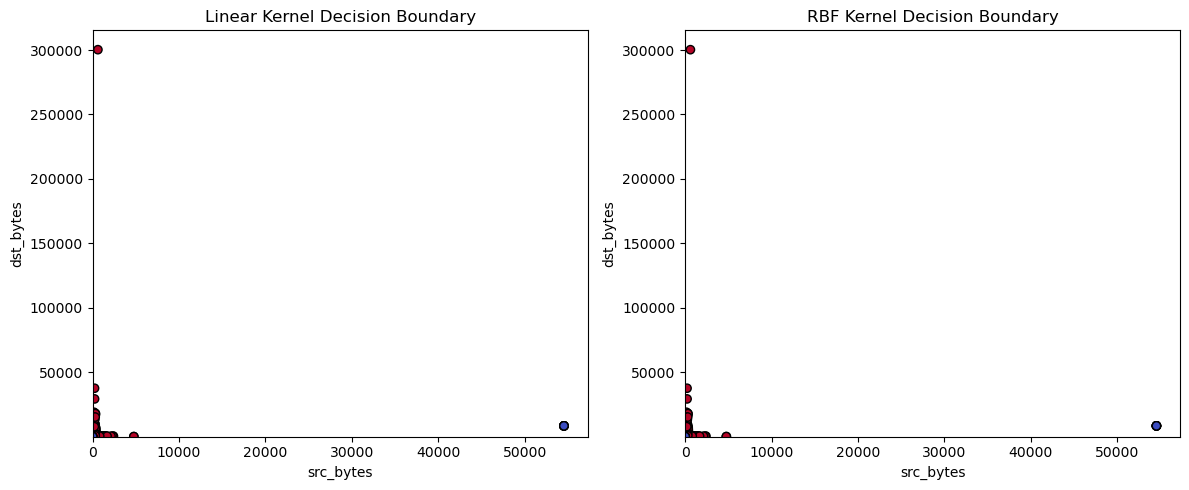

In [241]:
# Set up 1x2 grid for plotting


plt.figure(figsize=(12, 5))
# Plot decision boundary for linear kernel
plt.subplot(1, 2, 1)
Z_linear = svm_model_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)
plt.contourf(xx, yy, Z_linear, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2features_subsampled.iloc[:, 0], X_train_2features_subsampled.iloc[:, 1], c=y_train_subsampled, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
plt.title("Linear Kernel Decision Boundary")
plt.xlabel('src_bytes')
plt.ylabel('dst_bytes')

# Plot for RBF Kernel
plt.subplot(1, 2, 2)
Z_rbf = svm_model_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)
plt.contourf(xx, yy, Z_rbf, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2features_subsampled.iloc[:, 0], X_train_2features_subsampled.iloc[:, 1], c=y_train_subsampled, cmap=plt.cm.coolwarm, edgecolors='k', marker='o')
plt.title("RBF Kernel Decision Boundary")
plt.xlabel('src_bytes')
plt.ylabel('dst_bytes')

plt.tight_layout()
plt.show()